In [9]:
from meld_classifier.meld_cohort import MeldCohort, MeldSubject
import numpy as np
from scipy.stats import ttest_ind
import seaborn as sns
import pandas as pd
from meld_classifier.define_features import Feature
from meld_classifier.paths import BASE_PATH, EXPERIMENT_PATH,MELD_DATA_PATH
import sklearn.metrics as metrics

In [2]:
cohort= MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6.hdf5', dataset="MELD_dataset_V6.csv",
             data_dir=MELD_DATA_PATH)

In [3]:
# get all patients and controls
patient_ids = cohort.get_subject_ids(group='patient')
control_ids = cohort.get_subject_ids(group='control')
print(len(patient_ids), 'patients', len(control_ids), 'controls')

# get all features
for f in cohort.full_feature_list:
    print(f)

538 patients 373 controls
.combat.on_lh.curv.sm5.mgh
.combat.on_lh.gm_FLAIR_0.25.sm10.mgh
.combat.on_lh.gm_FLAIR_0.5.sm10.mgh
.combat.on_lh.gm_FLAIR_0.75.sm10.mgh
.combat.on_lh.gm_FLAIR_0.sm10.mgh
.combat.on_lh.pial.K_filtered.sm20.mgh
.combat.on_lh.sulc.sm5.mgh
.combat.on_lh.thickness.sm10.mgh
.combat.on_lh.w-g.pct.sm10.mgh
.combat.on_lh.wm_FLAIR_0.5.sm10.mgh
.combat.on_lh.wm_FLAIR_1.sm10.mgh
.inter_z.asym.intra_z.combat.on_lh.curv.sm5.mgh
.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.25.sm10.mgh
.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.5.sm10.mgh
.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.75.sm10.mgh
.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.sm10.mgh
.inter_z.asym.intra_z.combat.on_lh.pial.K_filtered.sm20.mgh
.inter_z.asym.intra_z.combat.on_lh.sulc.sm5.mgh
.inter_z.asym.intra_z.combat.on_lh.thickness.sm10.mgh
.inter_z.asym.intra_z.combat.on_lh.w-g.pct.sm10.mgh
.inter_z.asym.intra_z.combat.on_lh.wm_FLAIR_0.5.sm10.mgh
.inter_z.asym.intra_z.combat.on_lh.wm_FLAIR_1.sm10.mgh
.

In [ ]:
def get_subject_features(subject_ids, feature, cohort):
    """
    preload features from controls for a list of controls
    """
    n_vert = sum(cohort.cortex_mask)
    subject_data = {'features':{}, 'lesions': {}}
    subject_data['features']= np.zeros((len(subject_ids),2*n_vert))
    subject_data['lesions']= np.zeros((len(subject_ids),2*n_vert))
    for s,sid in enumerate(subject_ids):
        f=[]
        l=[]
        for h,hemi in enumerate(['lh', 'rh']):
            subj = MeldSubject(sid, cohort)
            features,lesion = subj.load_feature_lesion_data([feature], hemi=hemi)
            subject_data['features'][s,h*n_vert:(h+1)*n_vert] = features[cohort.cortex_mask].flatten()
            subject_data['lesions'][s,h*n_vert:(h+1)*n_vert] = lesion[cohort.cortex_mask]>0        
    return subject_data


def get_auc(all_features, bootstrap=False):
    subj_ids = np.arange(len(all_features))
    if bootstrap:
        #randomly with replacement
        subj_ids = np.random.choice(len(subj_ids),len(subj_ids))

    y_score = all_features['features'][subj_ids].ravel()
    label = all_features['lesions'][subj_ids].ravel()
    score = metrics.roc_auc_score(label, y_score)
    return 0.5+np.abs(0.5-score)

def get_auc_for_features(subject_ids, features, cohort):
    """
    calculate tstats for all patients + matching controls for all features in features dict
    """
    import time
    stats_c = {}
    for ftype, fdict in features.items():
        cur_stats_c = {}
        stats_c[ftype]=[]
        for fname, feature in fdict.items():
            subj_data = get_subject_features(subject_ids, feature, cohort)
            bootstrap_stats=[]
            for bs in np.arange(20):
                bootstrap_stats.append(get_auc(subj_data, bootstrap=True))
            cur_stats_c[fname]=np.array(bootstrap_stats)
        stats_c[ftype].append(cur_stats_c)
    return stats_c

In [166]:
#cohort.full_feature_list

## compare combat vs asym for noFLAIR features

In [192]:
# set up data for comparing combat vs asym features (no FLAIR features)
base_features = [
    '.on_lh.curv.mgh',
    '.on_lh.pial.K_filtered.mgh',
    '.on_lh.sulc.mgh',
   '.on_lh.thickness.mgh',
    '.on_lh.w-g.pct.mgh',
    ]
smooth = [5, 20, 5, 10, 10]

# build feature names for comparing combat vs asym
features = {
    'combat': {f:Feature(f, sm).get_combat_feature() for f,sm in zip(base_features, smooth)},
    'asym': {f:Feature(f, sm).get_asym_feature() for f,sm in zip(base_features, smooth)},
    'inter': {f:Feature(f, sm).get_norm_feature() for f,sm in zip(base_features, smooth)}
    
}
print(features)

# choose random controls to compare against
cur_control_ids = np.random.choice(control_ids, size=50, replace=False)

# Q: for FLAIR, choose only patients + controls that have flair
# Q: match scanner strength for patients + controls?

{'combat': {'.on_lh.curv.mgh': '.combat.on_lh.curv.sm5.mgh', '.on_lh.pial.K_filtered.mgh': '.combat.on_lh.pial.K_filtered.sm20.mgh', '.on_lh.sulc.mgh': '.combat.on_lh.sulc.sm5.mgh', '.on_lh.thickness.mgh': '.combat.on_lh.thickness.sm10.mgh', '.on_lh.w-g.pct.mgh': '.combat.on_lh.w-g.pct.sm10.mgh'}, 'asym': {'.on_lh.curv.mgh': '.inter_z.asym.intra_z.combat.on_lh.curv.sm5.mgh', '.on_lh.pial.K_filtered.mgh': '.inter_z.asym.intra_z.combat.on_lh.pial.K_filtered.sm20.mgh', '.on_lh.sulc.mgh': '.inter_z.asym.intra_z.combat.on_lh.sulc.sm5.mgh', '.on_lh.thickness.mgh': '.inter_z.asym.intra_z.combat.on_lh.thickness.sm10.mgh', '.on_lh.w-g.pct.mgh': '.inter_z.asym.intra_z.combat.on_lh.w-g.pct.sm10.mgh'}, 'inter': {'.on_lh.curv.mgh': '.inter_z.intra_z.combat.on_lh.curv.sm5.mgh', '.on_lh.pial.K_filtered.mgh': '.inter_z.intra_z.combat.on_lh.pial.K_filtered.sm20.mgh', '.on_lh.sulc.mgh': '.inter_z.intra_z.combat.on_lh.sulc.sm5.mgh', '.on_lh.thickness.mgh': '.inter_z.intra_z.combat.on_lh.thickness.sm10.mg

In [ ]:
ids = np.hstack([patient_ids[:100],cur_control_ids])
dict_scores=get_auc_for_features(ids, features, cohort)


In [ ]:
dfs=[]
for d in dict_scores.keys():
    df=pd.DataFrame(dict_scores[d][0])
    df['processing']=d
    dfs.append(df)
stats=pd.concat(dfs)

In [ ]:
# bring stats in right format for plotting
df = pd.melt(stats, id_vars='processing', var_name='feature', value_name='tstat') # value_vars=keys, value_name='key')
sns.boxplot(data=df, y='feature', x='tstat', hue='processing')

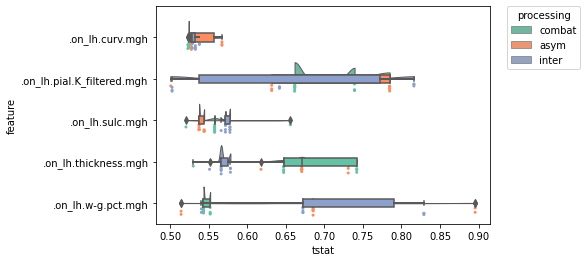

In [214]:
import ptitprince as pt

ax = pt.RainCloud(y = 'tstat', x = 'feature', hue='processing',
                  data = df, 
                  width_viol = .8,
                  width_box = .2,
                   orient = 'h',
                  move = .2,
                  offset=0)